In [1]:
import torch
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from PIL import Image


def center_crop_arr(pil_image, image_size):
    # We are not on a new enough PIL to support the `reducing_gap`
    # argument, which uses BOX downsampling at powers of two first.
    # Thus, we do it by hand to improve downsample quality.
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return arr[crop_y : crop_y + image_size, crop_x : crop_x + image_size]


def load_image(path, crop=False):
    img = Image.open(path)
    img = img.convert('RGB')
    if crop:
        img = center_crop_arr(img, 256)
    img = np.array(img)
    img = img.transpose(2, 0, 1)
    img = img / 255
    return img

In [2]:
img_t={}
diff = {}
diff_magn = {}
spin_t = {}

img_t[0] = load_image("../datasets/ILSVRC2012/validation/n02128757/n02128757_ILSVRC2012_val_00005277.JPEG", crop=True)
spin_t[0] = (img_t[0]-0.5)*2

for t in [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]:
    img_t[t] = load_image(f"../datasets/diffused_ILSVRC2012_validation/t_{t}_250_images/n02128757_ILSVRC2012_val_00005277_t{t*4:04d}.JPEG")
    diff[t] = img_t[t] - img_t[0]
    diff_magn[t] = np.linalg.norm(diff[t], axis=0)
    spin_t[t] = (img_t[t]-0.5)*2

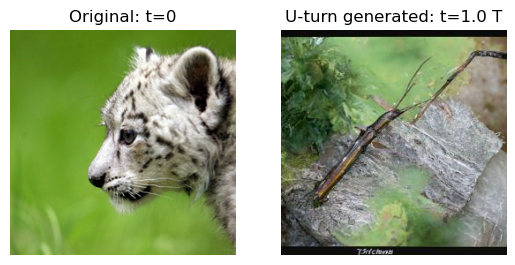

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


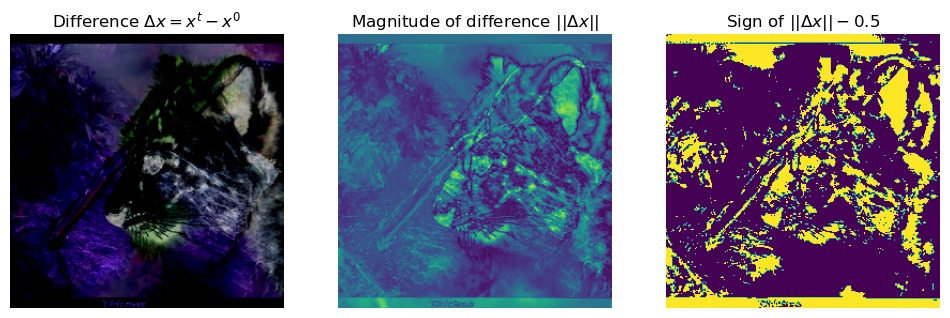

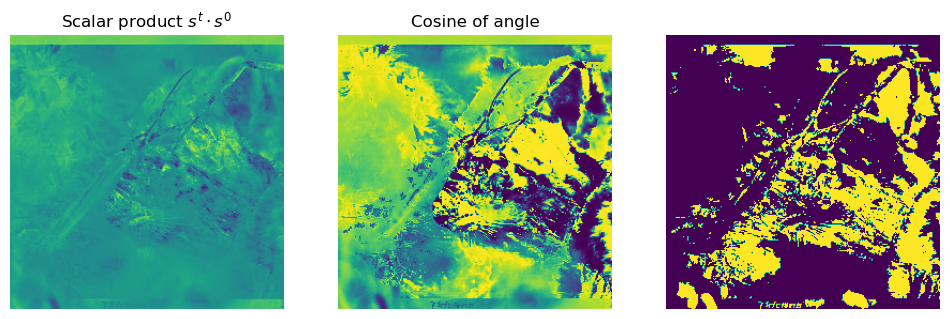

In [16]:
t = 250

fig, axs = plt.subplots(1, 2)

for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(img_t[0].transpose(1, 2, 0))
axs[1].imshow(img_t[t].transpose(1, 2, 0))
axs[0].set_title('Original: t=0')
axs[1].set_title(f'U-turn generated: t={(t/250):.1f} T')
# fig.savefig(f'../../plots/forw_back_corr-sample_img_t{t}.png', dpi = 300, bbox_inches='tight')
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(diff[t].transpose(1, 2, 0))
# axs[1].imshow(np.mean(diff, axis=0))
axs[1].imshow(diff_magn[t])
axs[2].imshow((np.sign(diff_magn[t]-0.5)+1)/2)
axs[0].set_title('Difference $\Delta x = x^t - x^0$')
axs[1].set_title('Magnitude of difference $||\Delta x||$')
axs[2].set_title('Sign of $||\Delta x|| - 0.5$')
# fig.savefig(f'../../plots/forw_back_corr-diff_img_t{t}.png', dpi = 300, bbox_inches='tight')
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

scalar = np.sum(spin_t[t]*spin_t[0], axis=0)
cos_angle = scalar / (np.linalg.norm(spin_t[t], axis=0) * np.linalg.norm(spin_t[0], axis=0))

for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(scalar)
axs[1].imshow(cos_angle)
axs[2].imshow(np.sign(np.arccos(cos_angle)-np.pi/2))
axs[0].set_title('Scalar product $s^t \cdot s^0$')
axs[1].set_title('Cosine of angle')
# axs[2].set_title('Sign of $pi/2 - \arccos$')
# fig.savefig(f'../../plots/forw_back_corr-spin_img_t{t}.png', dpi = 300, bbox_inches='tight')
plt.show()

In [83]:
cos_angle

array([[0.98237915, 0.98554169, 0.96888678, ..., 1.09130319, 1.09585624,
        1.09585624],
       [1.02885437, 1.03211131, 0.9972739 , ..., 1.06834419, 1.09585624,
        1.0867017 ],
       [1.07347817, 1.0777395 , 1.04136701, ..., 1.07982369, 1.09585624,
        1.10733574],
       ...,
       [0.73733159, 0.76254384, 0.75658627, ..., 0.55286349, 0.36043229,
        0.23638681],
       [0.71845662, 0.72744605, 0.73238024, ..., 0.46137155, 0.3890648 ,
        0.26782041],
       [0.70743492, 0.72096624, 0.73470964, ..., 0.55234115, 0.4922967 ,
        0.30817099]])

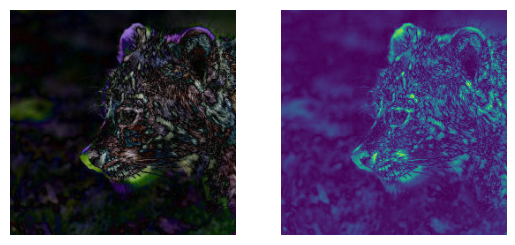

In [32]:
# Visualize the difference between the two images
diff = np.abs(img_t150 - img_t0)
diff_magn = np.sum((img_t150 - img_t0)**2, axis=0)**.5

fig, axs = plt.subplots(1, 2)

for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(diff.transpose(1, 2, 0))
# axs[1].imshow(np.mean(diff, axis=0))
axs[1].imshow(diff_magn)
plt.show()



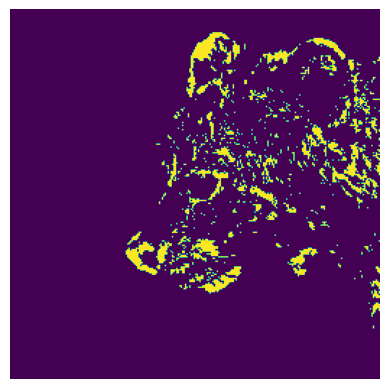

In [35]:
fig, ax = plt.subplots()
ax.axis('off')
ax.set_aspect('equal')
ax.imshow((np.sign(diff_magn-0.5)+1)/2)
plt.show()

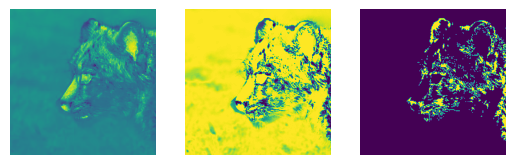

In [52]:
spin_t150 = (img_t150-0.5)*2
spin_t0 = (img_t0-0.5)*2

scalar = np.sum(spin_t150*spin_t0, axis=0)
cos_angle = scalar / (np.sum(spin_t150**2, axis=0)**.5 * np.sum(spin_t0**2, axis=0)**.5)

fig, axs = plt.subplots(1,3)
for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(scalar)
axs[1].imshow(cos_angle)
axs[2].imshow(np.sign(np.arccos(cos_angle)-np.pi/2))
plt.show()

In [51]:
np.arccos(cos_angle).max()

3.1306960721114434

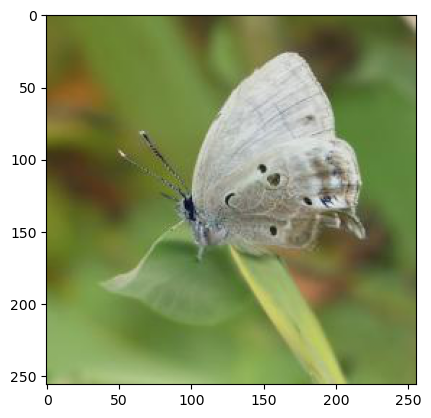

In [55]:
img_t175 = load_image("../datasets/diffused_ILSVRC2012_validation/t_175_250_images/n02128757_ILSVRC2012_val_00005277_t0700.JPEG")
plt.imshow(img_t175.transpose(1, 2, 0))

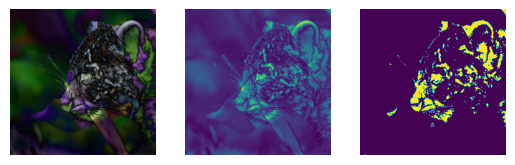

In [56]:
# Visualize the difference between the two images
diff = np.abs(img_t175 - img_t0)
diff_magn = np.sum((img_t175 - img_t0)**2, axis=0)**.5

fig, axs = plt.subplots(1, 3)

for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(diff.transpose(1, 2, 0))
axs[1].imshow(diff_magn)
axs[2].imshow((np.sign(diff_magn-0.5)+1)/2)
plt.show()



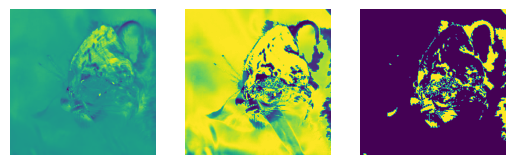

In [57]:
spin_t175 = (img_t175-0.5)*2
spin_t0 = (img_t0-0.5)*2

scalar = np.sum(spin_t175*spin_t0, axis=0)
cos_angle = scalar / (np.sum(spin_t175**2, axis=0)**.5 * np.sum(spin_t0**2, axis=0)**.5)

fig, axs = plt.subplots(1,3)
for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(scalar)
axs[1].imshow(cos_angle)
axs[2].imshow(np.sign(np.arccos(cos_angle)-np.pi/2))
plt.show()

In [ ]:
diff = {}
diff_magn = {}
spin_t = {}


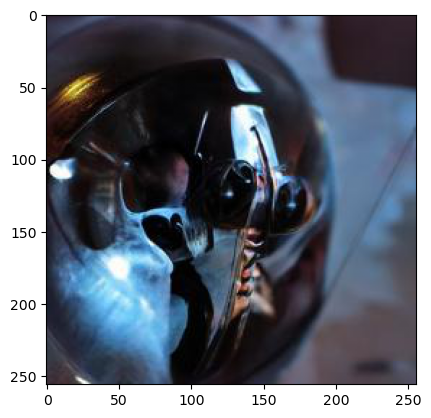

In [67]:
img_t={}
t = 225
img_t[t] = load_image(f"../datasets/diffused_ILSVRC2012_validation/t_{t}_250_images/n02128757_ILSVRC2012_val_00005277_t{t*4:04d}.JPEG")
plt.imshow(img_t[t].transpose(1, 2, 0))

In [62]:
# Visualize the difference between the two images
diff = {}
diff_magn = {}
diff = np.abs(img_t175 - img_t0)
diff_magn = np.sum((img_t175 - img_t0)**2, axis=0)**.5

fig, axs = plt.subplots(1, 3)

for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(diff.transpose(1, 2, 0))
axs[1].imshow(diff_magn)
axs[2].imshow((np.sign(diff_magn-0.5)+1)/2)
plt.show()



'0900'

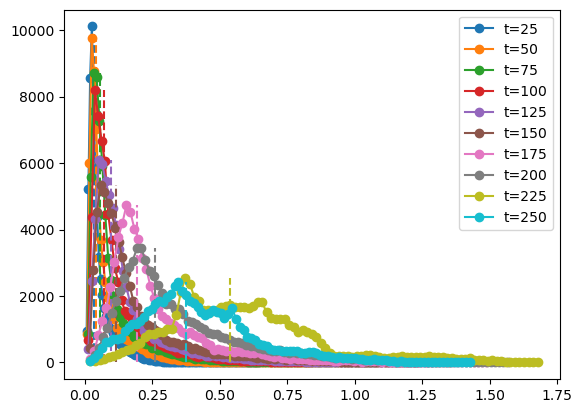

In [3]:
for it, tt in enumerate(diff_magn.keys()):
    hist, hx = np.histogram(diff_magn[tt].flatten(), 100);
    mm = np.median(diff_magn[tt])
    plt.plot(hx[1:], hist, 'o-', label=f't={tt}', color=f"C{it}");
    plt.vlines(mm, 0, hist.max(), color=f"C{it}", linestyle='--',)
plt.legend()

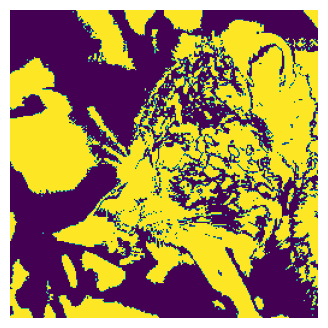

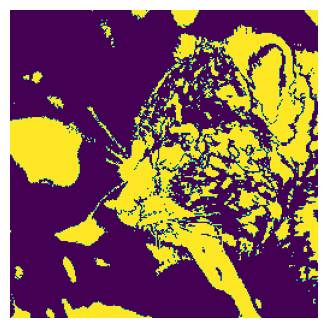

In [5]:
# tt=250
tt=175

fig, ax = plt.subplots(figsize=(4, 4))

ax.axis('off')
ax.set_aspect('equal')

discr = 2*((diff_magn[tt] > np.median(diff_magn[tt])) - 0.5)

ax.imshow(discr)
# fig.savefig(f'../../plots/forw_back_corr-diff_img_t{tt}-spin_median.png', dpi = 300, bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(figsize=(4, 4))

ax.axis('off')
ax.set_aspect('equal')

discr = 2*((diff_magn[tt] > 1*np.mean(diff_magn[tt])) - 0.5)

ax.imshow(discr)
# fig.savefig(f'../../plots/forw_back_corr-diff_img_t{tt}-spin_mean.png', dpi = 300, bbox_inches='tight')
plt.show()



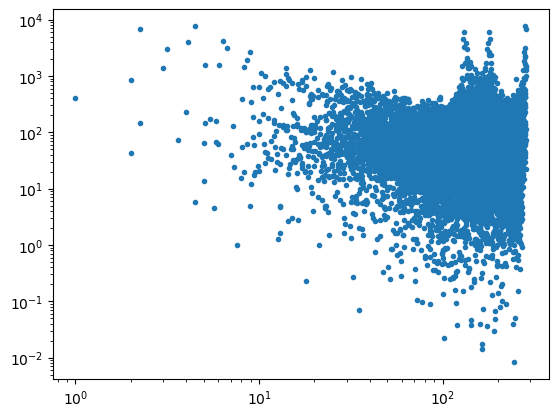

In [22]:
kx, ky = np.meshgrid(np.arange(256), np.arange(129))
k_vec = (kx**2 + ky**2)**0.5

ft = np.fft.rfft2(discr)
plt.loglog(k_vec.flatten(), (np.real(ft)**1).flatten(), '.')

/tmp/ipykernel_30021/3053375931.py:11: RuntimeWarning: divide by zero encountered in power
  plt.loglog(k_vec, 5*ft[1]*(k_vec/k_vec[1])**(-2), 'k--', label='$k^{-2}$')
/tmp/ipykernel_30021/3053375931.py:12: RuntimeWarning: divide by zero encountered in reciprocal
  plt.loglog(k_vec, 2*ft[1]*(k_vec/k_vec[1])**(-1), 'r--', label='$k^{-1}$')


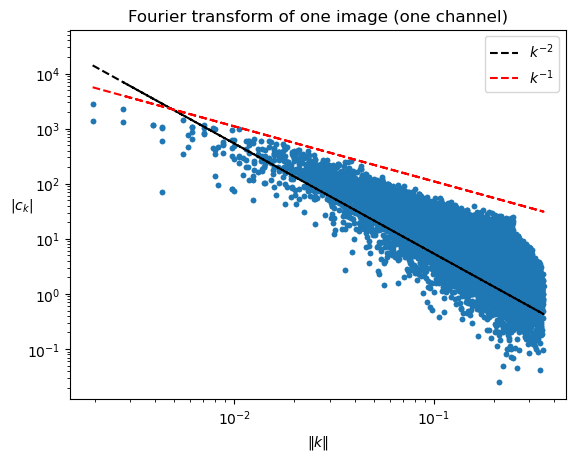

In [10]:
kx, ky = np.meshgrid(np.fft.fftfreq(256, 2), np.fft.fftfreq(256, 2))
k_vec = (kx**2 + ky**2)**0.5
k_vec = k_vec.flatten()

# np.fft.rfftfreq(256, 2)

ft = np.fft.fft2(img_t[0][0])
ft = np.abs(ft).flatten()
# ft = np.fft.fftshift(ft)
plt.loglog(k_vec, ft, '.')
plt.loglog(k_vec, 5*ft[1]*(k_vec/k_vec[1])**(-2), 'k--', label='$k^{-2}$')
plt.loglog(k_vec, 2*ft[1]*(k_vec/k_vec[1])**(-1), 'r--', label='$k^{-1}$')

plt.legend()
plt.xlabel('$\|k\|$')
plt.ylabel('$|c_k|$', rotation=0)

plt.title('Fourier transform of one image (one channel)')

# plt.savefig(f'../../plots/forw_back_corr-fft_img_t{0}.png', dpi = 300, bbox_inches='tight')

/tmp/ipykernel_26690/2821469477.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  plt.loglog(k_vec, 1e4*(k_vec/k_vec[1])**(-1), 'k--')


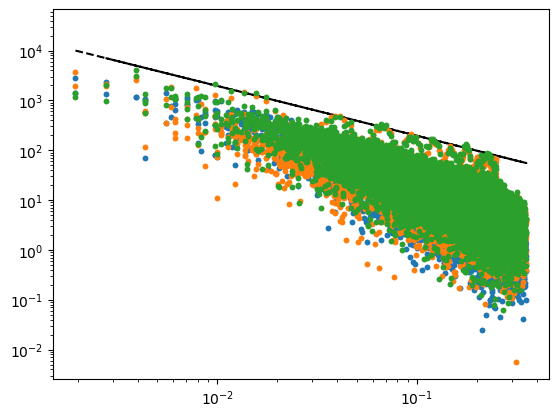

In [33]:
# kx, ky = np.meshgrid(np.arange(256), np.arange(129))
# k_vec = (kx**2 + ky**2)**0.5
# k_vec = k_vec.flatten()

# kx = np.fft.fftfreq(256, 2)
# ky = np.fft.rfftfreq(256, 2)
kx, ky = np.meshgrid(np.fft.fftfreq(256, 2), np.fft.fftfreq(256, 2))
k_vec = (kx**2 + ky**2)**0.5
k_vec = k_vec.flatten()

# np.fft.rfftfreq(256, 2)

ft = np.fft.fft2(img_t[0][0])
ft = np.abs(ft).flatten()
plt.loglog(k_vec, (np.abs(ft)**1).flatten(), '.')
plt.loglog(k_vec, 1e4*(k_vec/k_vec[1])**(-1), 'k--')

ft = np.fft.fft2(img_t[250][0])
ft = np.abs(ft).flatten()
plt.loglog(k_vec, (np.abs(ft)**1).flatten(), '.')
# plt.loglog(k_vec, 1e4*(k_vec/k_vec[1])**(-1), 'k--')

ft = np.fft.fft2(diff[250][0])
ft = np.abs(ft).flatten()
plt.loglog(k_vec, (np.abs(ft)**1).flatten(), '.')


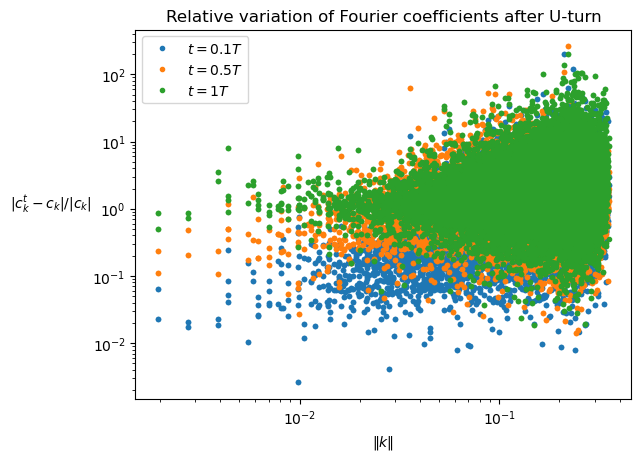

In [15]:
ft0 = np.fft.fft2(img_t[0][0])
ftt = np.fft.fft2(img_t[25][0])

# ft0 = np.abs(ft0).flatten()
# ftt = np.abs(ftt).flatten()

# plt.loglog(ft0, ftt, '.')

rel_diff = np.abs(ftt - ft0) / np.abs(ft0)
rel_diff = rel_diff.flatten()

plt.loglog(k_vec, rel_diff, '.', label='$t= 0.1 T$')


ft0 = np.fft.fft2(img_t[0][0])
ftt = np.fft.fft2(img_t[125][0])
rel_diff = np.abs(ftt - ft0) / np.abs(ft0)
rel_diff = rel_diff.flatten()

plt.loglog(k_vec, rel_diff, '.', label='$t= 0.5 T$')


ft0 = np.fft.fft2(img_t[0][0])
ftt = np.fft.fft2(img_t[250][0])
rel_diff = np.abs(ftt - ft0) / np.abs(ft0)
rel_diff = rel_diff.flatten()

plt.loglog(k_vec, rel_diff, '.', label='$t= 1 T$')


plt.legend()
plt.xlabel('$\|k\|$')
plt.ylabel('$|c_k^t - c_k| / |c_k|$', rotation=0, labelpad=30)

plt.title('Relative variation of Fourier coefficients after U-turn')

plt.savefig(f'../../plots/forw_back_corr-relative_variation_fourier.png', dpi = 300, bbox_inches='tight')

In [32]:
d_img = torch.tensor(diff_magn[tt]).unsqueeze(0)

In [33]:
d_img > d_img.median()

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [45]:
d_img = d_img.flatten(start_dim=1)
d_img > torch.median(d_img, dim=-1, keepdim=True).values

tensor([[True, True, True,  ..., True, True, True]])

# Test Fourier coefficients

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

In [2]:
6000**.5

77.45966692414834

Namespace(clip_denoised=True, num_samples=10000, batch_size=32, use_ddim=False, model_path='models/256x256_diffusion_uncond.pt', image_size=256, num_channels=256, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=64, attention_resolutions='32,16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=True, use_fp16=True, use_new_attention_order=False, learn_sigma=True, diffusion_steps=1000, noise_schedule='linear', timestep_respacing='250', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False, step_reverse=25, data_dir='/scratch/izar/sclocchi/datasets/ILSVRC2012/validation', output='/scratch/izar/sclocchi/guided-diffusion/results/diffused_ILSVRC2012_validation', num_per_class=10, num_classes=1000)


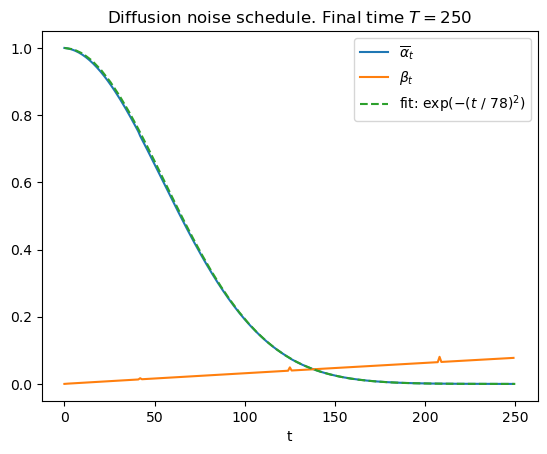

In [2]:
file_args = '../datasets/diffused_ILSVRC2012_validation/t_25_250_args_2024-01-19-23-29-10-184671.pk'
with open(file_args, 'rb') as f:
    args = pickle.load(f)
print(args)

_, diffusion = create_model_and_diffusion(
    **args_to_dict(args, model_and_diffusion_defaults().keys())
)

betas = np.array(diffusion.betas)
alpha_bar = np.array(diffusion.alphas_cumprod)

fig, ax = plt.subplots()
plt.plot(diffusion.alphas_cumprod, label='$\\overline{\\alpha}_t$')
plt.plot(diffusion.betas, label='$\\beta_t$')
tv = np.linspace(0, 250)
plt.plot(tv, np.exp(-(tv/78)**2), '--', label='fit: $\exp(-(t\ /\ 78)^2)$')
plt.xlabel('t')
plt.title('Diffusion noise schedule. Final time $T=250$')
plt.legend()
# plt.savefig(f'../../plots/forw_back_corr-diffusion_schedule.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [3]:
folder = '../Fourier_coefficients/diffused_ILSVRC2012_validation/'
file_list = [folder+'/'+f for f in os.listdir(folder) if 'delta_ck-t' in f]

data = {}
for file in file_list:
    key = int(file.split('_')[-2])
    with open(file, 'rb') as f:
        delta_ck = pickle.load(f)
    data[key] = delta_ck

print(sorted(data.keys()))
print(delta_ck.keys())
print(delta_ck['mean_delta_ck_norm2'].shape)
print(delta_ck['mean_ck0_norm2'].shape)

[25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
dict_keys(['mean_abs_delta_ck', 'mean_delta_ck_norm2', 'mean_abs_ck0', 'mean_ck0_norm2', 'mean_delta_ck_over_ck0'])
(256, 256)
(256, 256)


In [5]:
np.fft.fftfreq(256, 2).shape

(256,)

In [4]:
kx, ky = np.meshgrid(np.fft.fftfreq(256, 2), np.fft.fftfreq(256, 2))
k_vec = (kx**2 + ky**2)**0.5
k_vec = k_vec.flatten()

/tmp/ipykernel_19227/1727045426.py:8: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-1.25), 'k--', label='$\|k\|^{-1.25}$')
/tmp/ipykernel_19227/1727045426.py:8: RuntimeWarning: invalid value encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-1.25), 'k--', label='$\|k\|^{-1.25}$')
/tmp/ipykernel_19227/1727045426.py:9: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kval, 1.5e2*(kval/kval[-1])**(-1.05), 'r--', label='$\|k\|^{-1.05}$')
/tmp/ipykernel_19227/1727045426.py:9: RuntimeWarning: invalid value encountered in power
  plt.loglog(kval, 1.5e2*(kval/kval[-1])**(-1.05), 'r--', label='$\|k\|^{-1.05}$')


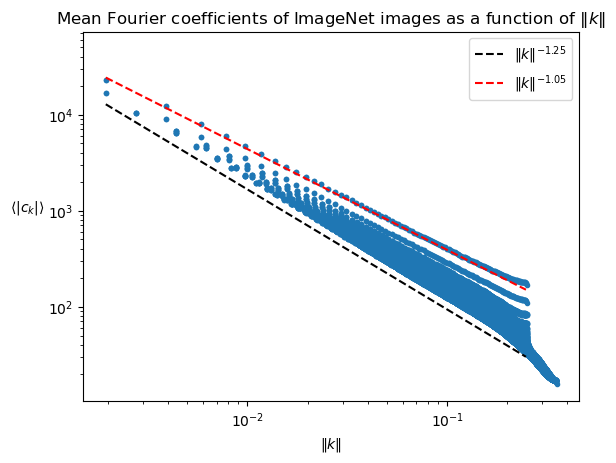

In [5]:
kval = np.fft.fftfreq(256, 2)

fig, ax = plt.subplots()
# for ik, key in enumerate(sorted(data.keys())):
plt.loglog(k_vec, (data[25]['mean_abs_ck0']).flatten(), '.')

kval = np.sort(kval)
plt.loglog(kval, 3e1*(kval/kval[-1])**(-1.25), 'k--', label='$\|k\|^{-1.25}$')
plt.loglog(kval, 1.5e2*(kval/kval[-1])**(-1.05), 'r--', label='$\|k\|^{-1.05}$')

plt.xlabel('$\|k\|$')
plt.ylabel('$\\langle |c_k| \\rangle$', rotation=0, labelpad=15)
plt.legend()
plt.title('Mean Fourier coefficients of ImageNet images as a function of $\|k\|$')
# plt.savefig(f'../../plots/forw_back_corr-mean_fourier_coefficients.png', dpi = 300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_19227/337535027.py:8: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kval, .6e3*(kval/kval[-1])**(-2*1.25), 'k--', label='$\|k\|^{-2.5}$')
/tmp/ipykernel_19227/337535027.py:8: RuntimeWarning: invalid value encountered in power
  plt.loglog(kval, .6e3*(kval/kval[-1])**(-2*1.25), 'k--', label='$\|k\|^{-2.5}$')
/tmp/ipykernel_19227/337535027.py:9: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kval, 1.5e4*(kval/kval[-1])**(-2*1.05), 'r--', label='$\|k\|^{-2.1}$')
/tmp/ipykernel_19227/337535027.py:9: RuntimeWarning: invalid value encountered in power
  plt.loglog(kval, 1.5e4*(kval/kval[-1])**(-2*1.05), 'r--', label='$\|k\|^{-2.1}$')


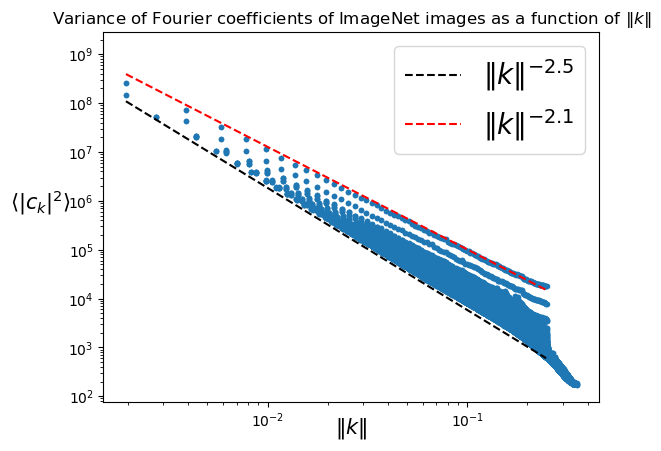

In [6]:
kval = np.fft.fftfreq(256, 2)

fig, ax = plt.subplots()
# for ik, key in enumerate(sorted(data.keys())):
plt.loglog(k_vec, (data[25]['mean_ck0_norm2']).flatten(), '.')

kval = np.sort(kval)
plt.loglog(kval, .6e3*(kval/kval[-1])**(-2*1.25), 'k--', label='$\|k\|^{-2.5}$')
plt.loglog(kval, 1.5e4*(kval/kval[-1])**(-2*1.05), 'r--', label='$\|k\|^{-2.1}$')

plt.xlabel('$\|k\|$', fontsize=15, labelpad=-10)
plt.ylabel('$\\langle |c_k|^2 \\rangle$', rotation=0, labelpad=20, fontsize=15)
plt.legend(prop={'size': 20})
plt.title('Variance of Fourier coefficients of ImageNet images as a function of $\|k\|$')
# plt.savefig(f'../../plots/forw_back_corr-mean_fourier_coefficients.png', dpi = 300, bbox_inches='tight')
# plt.savefig(f'../../plots/forw_back_corr-var_fourier_coefficients.png', dpi = 300, bbox_inches='tight')
plt.show()

In [11]:
print(data.keys())
print(data[25].keys())

dict_keys([75, 225, 25, 50, 150, 100, 200, 250, 175, 125])
dict_keys(['mean_abs_delta_ck', 'mean_delta_ck_norm2', 'mean_abs_ck0', 'mean_ck0_norm2', 'mean_delta_ck_over_ck0'])


In [7]:
kx, ky = np.meshgrid(np.fft.fftfreq(256, 2), np.fft.fftfreq(256, 2))
k_vec = (kx**2 + ky**2)**0.5
k_vec = k_vec.flatten()
print(k_vec.shape)

k_bins = torch.logspace(-3, 0, 20)
histo_idx = torch.bucketize(torch.tensor(k_vec), k_bins)
num = torch.zeros_like(k_bins, dtype=torch.float64).scatter_add_(0, histo_idx, torch.ones_like(torch.tensor(k_vec)))

mean_data = {}
std_data = {}
for time_key in data.keys():
    mean_data[time_key] = {}
    std_data[time_key] = {}
    for key in data[time_key].keys():
        val_k = torch.tensor(data[time_key][key])
        mean_val = torch.zeros_like(k_bins, dtype=torch.float32).scatter_add_(0, histo_idx, val_k.flatten()) 
        mean_sq_val = torch.zeros_like(k_bins, dtype=torch.float32).scatter_add_(0, histo_idx, (val_k.flatten())**2) 
        mean_data[time_key][key] = mean_val / num.float()
        std_data[time_key][key] = (mean_sq_val / num.float() - (mean_val / num.float())**2).sqrt()

(65536,)


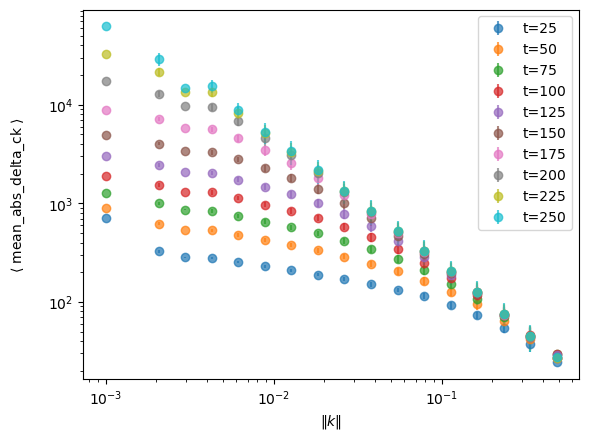

In [26]:
# key = 'mean_abs_ck0'
key = 'mean_abs_delta_ck'
# key='mean_delta_ck_over_ck0'

fig, ax = plt.subplots()
for time_key in sorted(mean_data.keys()):
    # plt.loglog(k_bins, mean_data[time_key][key], '.', label=f't={time_key}')
    plt.errorbar(k_bins, mean_data[time_key][key], yerr=std_data[time_key][key], fmt='o', label=f't={time_key}', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\|k\|$')
plt.ylabel(f'$\\langle$ {key} $\\rangle$', rotation=90, labelpad=15)
plt.legend()
plt.show()


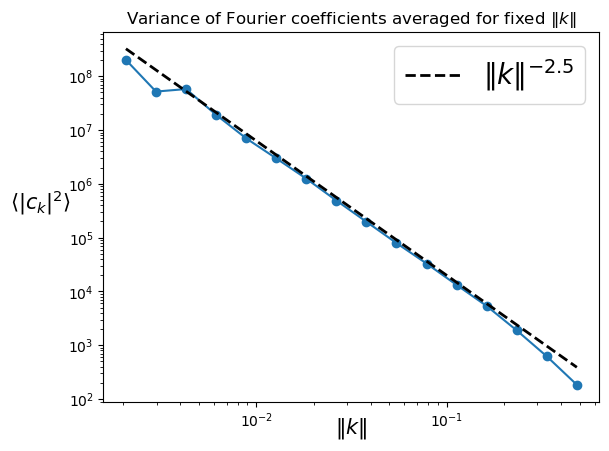

In [34]:
expo_a = 1.25 * 2
cut = -2
cut_t = 2

fig, ax = plt.subplots()
ax.loglog(k_bins[cut_t:], mean_data[25]['mean_ck0_norm2'][cut_t:], 'o-',)
# for time_key in sorted(mean_data.keys()):
    # k_star = (alpha_bar[time_key-1]**(-1) - 1)**(-1/expo_a)
    # ax.loglog(k_bins[cut_t:], mean_data[time_key]['mean_abs_delta_ck'][cut_t:]/mean_data[time_key]['mean_abs_ck0'][cut_t:], 'o-', label=f't={time_key}')
    # plt.errorbar(k_bins, mean_data[time_key][key], yerr=std_data[time_key][key], fmt='o', label=f't={time_key}', alpha=0.7)
ax.loglog(k_bins[cut_t:cut], 2e9*(k_bins[cut_t:cut]/k_bins[0])**(-expo_a), 'k--', lw=2, label='$\|k\|^{-2.5}$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('$\|k\|$', fontsize=15, labelpad=-10)
plt.ylabel('$\\langle |c_k|^2 \\rangle$', rotation=0, labelpad=20, fontsize=15)
ax.legend(prop={'size': 20})
plt.title("Variance of Fourier coefficients averaged for fixed $\|k\|$")
# plt.savefig(f'../../plots/var_fourier_coefficients-averaged.pdf', dpi = 300, bbox_inches='tight')


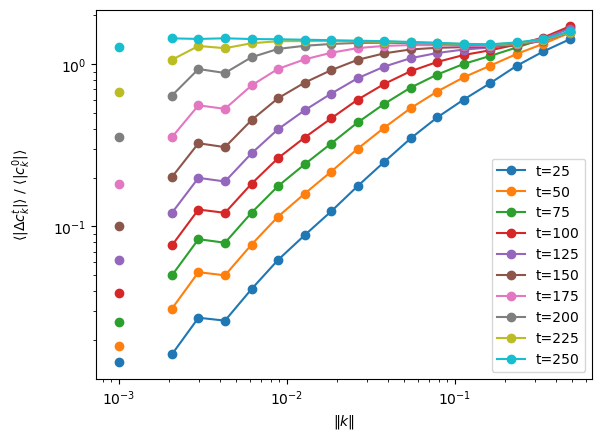

In [30]:
# # key = 'mean_abs_ck0'
# key = 'mean_abs_delta_ck'
# # key='mean_delta_ck_over_ck0'

fig, ax = plt.subplots()
for time_key in sorted(mean_data.keys()):
    plt.loglog(k_bins, mean_data[time_key]['mean_abs_delta_ck']/mean_data[time_key]['mean_abs_ck0'], 'o-', label=f't={time_key}')
    # plt.errorbar(k_bins, mean_data[time_key][key], yerr=std_data[time_key][key], fmt='o', label=f't={time_key}', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\|k\|$')
plt.ylabel(f'$\\langle |\Delta c_k^t| \\rangle$ / $\\langle |c_k^0| \\rangle$', rotation=90, labelpad=15)
plt.legend()
plt.show()


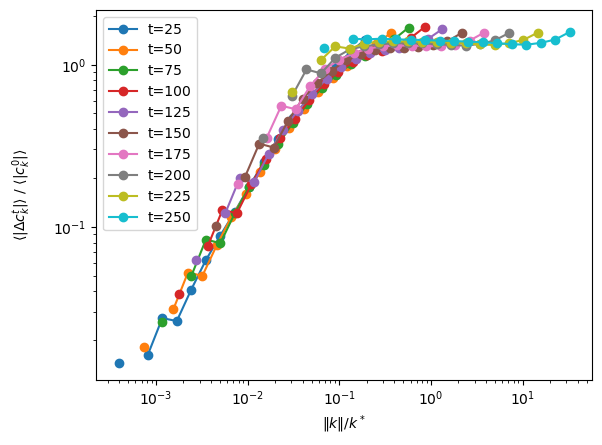

In [31]:
expo_a = 2.4

fig, ax = plt.subplots()
for time_key in sorted(mean_data.keys()):
    k_star = (alpha_bar[time_key-1]**(-1) - 1)**(-1/expo_a)
    plt.loglog(k_bins / k_star, mean_data[time_key]['mean_abs_delta_ck']/mean_data[time_key]['mean_abs_ck0'], 'o-', label=f't={time_key}')
    # plt.errorbar(k_bins, mean_data[time_key][key], yerr=std_data[time_key][key], fmt='o', label=f't={time_key}', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\|k\| / k^*$')
plt.ylabel(f'$\\langle |\Delta c_k^t| \\rangle$ / $\\langle |c_k^0| \\rangle$', rotation=90, labelpad=15)
plt.legend()
plt.show()

# Add inset with the plot of the previous cell




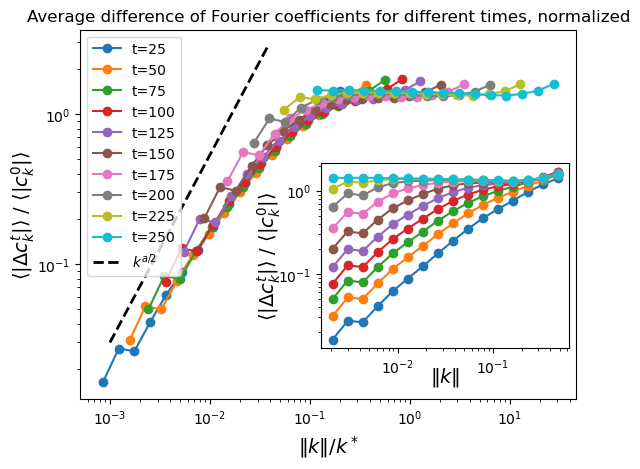

In [47]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

expo_a = 2.5
cut = 11
cut_t = 1

fig, ax = plt.subplots()
for time_key in sorted(mean_data.keys()):
    k_star = (alpha_bar[time_key-1]**(-1) - 1)**(-1/expo_a)
    ax.loglog(k_bins[cut_t:] / k_star, mean_data[time_key]['mean_abs_delta_ck'][cut_t:]/mean_data[time_key]['mean_abs_ck0'][cut_t:], 'o-', label=f't={time_key}')
    # plt.errorbar(k_bins, mean_data[time_key][key], yerr=std_data[time_key][key], fmt='o', label=f't={time_key}', alpha=0.7)
ax.loglog(k_bins[:cut], 3e-2*(k_bins[:cut]/k_bins[0])**(expo_a/2), 'k--', lw=2, label='$k^{a/2}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\|k\| / k^*$', fontsize = 14)
ax.set_ylabel(f'$\\langle |\Delta c_k^t| \\rangle$ / $\\langle |c_k^0| \\rangle$', rotation=90, labelpad=0, fontsize = 14)
ax.legend(loc=2)
# ax.set_xlim(1e-4, 4e1)

# Create inset of the plot from cell 30
inset_ax = inset_axes(ax, width="50%", height="50%", loc='lower right', bbox_to_anchor=(-0.0, 0.12, 1, 1), bbox_transform=ax.transAxes)
for time_key in sorted(mean_data.keys()):
    inset_ax.loglog(k_bins[cut_t:], mean_data[time_key]['mean_abs_delta_ck'][cut_t:]/mean_data[time_key]['mean_abs_ck0'][cut_t:], 'o-', label=f't={time_key}')
inset_ax.set_xscale('log')
inset_ax.set_yscale('log')
inset_ax.set_xlabel('$\|k\|$', labelpad = -8, fontsize = 14)
inset_ax.set_ylabel(f'$\\langle |\Delta c_k^t| \\rangle$ / $\\langle |c_k^0| \\rangle$', rotation=90, labelpad=-3, fontsize = 14)
# move the ylabel
# inset_ax.yaxis.set_label_position("right")

ax.set_title('Average difference of Fourier coefficients for different times, normalized')
# plt.savefig(f'../../plots/forw_back_corr-mean_fourier_coefficients-inset.png', dpi = 300, bbox_inches='tight')
plt.show()

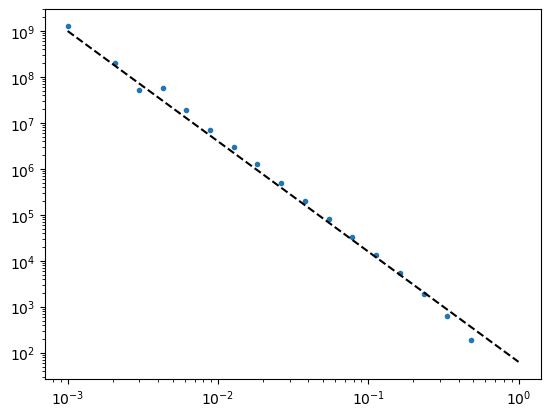

In [16]:
plt.loglog(bins, res, '.')
plt.loglog(bins, 1e9*(bins/bins[0])**(-2.4), 'k--')

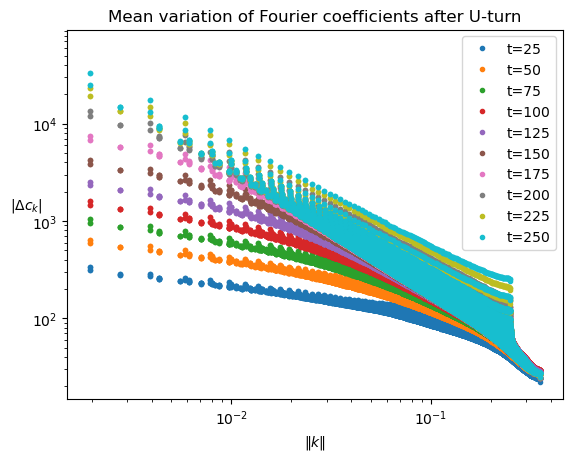

In [7]:
for key in sorted(data.keys()):
    # plt.loglog(k_vec, data[key]['mean_delta_ck_norm2'].flatten(), '.', label=f't={key}')
    plt.loglog(k_vec, data[key]['mean_abs_delta_ck'].flatten(), '.', label=f't={key}')
plt.legend()
plt.xlabel('$\|k\|$')
plt.ylabel('$|\Delta c_k|$', rotation=0)
plt.title('Mean variation of Fourier coefficients after U-turn')
# plt.savefig(f'../../plots/forw_back_corr-mean_variation_fourier.png', dpi = 300, bbox_inches='tight')
plt.show()

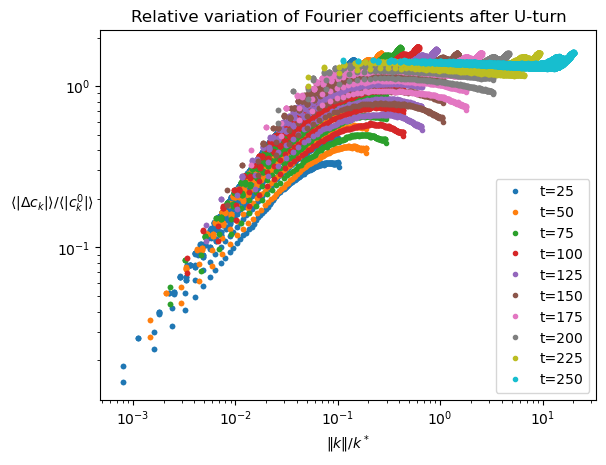

In [13]:
expo_a = 2*1.25
cut = 10
for ik, key in enumerate(sorted(data.keys())[:10]):
    # print(ik)
    k_star = (alpha_bar[key-1]**(-1) - 1)**(-1/expo_a)
    ystar = (data[key]['mean_abs_delta_ck']/ data[key]['mean_abs_ck0']).mean()**(-1)
    ystar = 1.
    # k_star = 1.
    # plt.loglog(k_vec / k_star, (data[key]['mean_delta_ck_norm2'].flatten() / data[key]['mean_ck0_norm2'].flatten())**.5, '.', label=f't={key}')
    # plt.loglog(k_vec / k_star, ystar*(data[key]['mean_abs_delta_ck'].flatten() / data[key]['mean_abs_ck0'].flatten()), '.', label=f't={key}')
    # plt.loglog(np.fft.fftfreq(256, 2) / k_star, ystar*(data[key]['mean_abs_delta_ck'].mean(axis=1)/ data[key]['mean_abs_ck0'].mean(axis=1)), '.', label=f't={key}')
    plt.loglog(k_vec / k_star, ystar*(data[key]['mean_abs_delta_ck']/ data[key]['mean_abs_ck0']).flatten(), '.', label=f't={key}')
plt.legend()
plt.xlabel('$\|k\|/ k^*$')
plt.ylabel('$\langle |\Delta c_k|\\rangle / \langle |c_k^0| \\rangle$', rotation=0)
plt.title('Relative variation of Fourier coefficients after U-turn')
# plt.savefig(f'../../plots/forw_back_corr-relative_variation_fourier.png', dpi = 300, bbox_inches='tight')
plt.show()

In [156]:
data[key].keys()

dict_keys(['mean_abs_delta_ck', 'mean_delta_ck_norm2', 'mean_abs_ck0', 'mean_ck0_norm2', 'mean_delta_ck_over_ck0'])

In [157]:
k_vec.shape
data[key]['mean_abs_delta_ck'].shape

(256, 256)

/tmp/ipykernel_25981/3168273080.py:5: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-0.75), 'k--')
/tmp/ipykernel_25981/3168273080.py:5: RuntimeWarning: invalid value encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-0.75), 'k--')


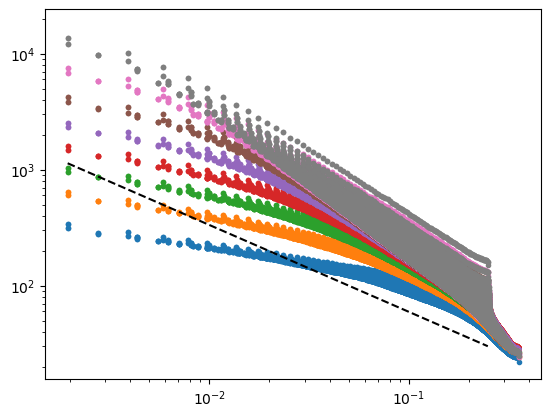

In [159]:
kval = np.fft.fftfreq(256, 2)
for ik, key in enumerate(sorted(data.keys())[:8]):
    plt.loglog(k_vec, (data[key]['mean_abs_delta_ck']).flatten(), '.', label=f't={key}')
kval = np.sort(kval)
plt.loglog(kval, 3e1*(kval/kval[-1])**(-0.75), 'k--')
plt.show()

/tmp/ipykernel_25981/1592681852.py:5: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-1.25), 'k--')
/tmp/ipykernel_25981/1592681852.py:5: RuntimeWarning: invalid value encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-1.25), 'k--')


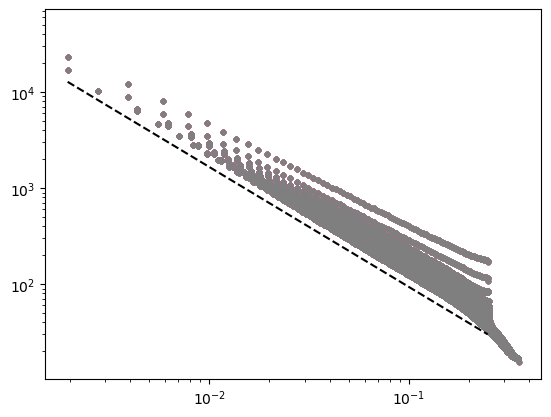

In [173]:
kval = np.fft.fftfreq(256, 2)
for ik, key in enumerate(sorted(data.keys())[:8]):
    plt.loglog(k_vec, (data[key]['mean_abs_ck0']).flatten(), '.', label=f't={key}')
kval = np.sort(kval)
plt.loglog(kval, 3e1*(kval/kval[-1])**(-1.25), 'k--')
plt.show()

/tmp/ipykernel_25981/688949130.py:11: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kvals / k_star, 5e1*(kvals/kvals[-1])**(-.5), 'k--')
/tmp/ipykernel_25981/688949130.py:11: RuntimeWarning: invalid value encountered in power
  plt.loglog(kvals / k_star, 5e1*(kvals/kvals[-1])**(-.5), 'k--')
/tmp/ipykernel_25981/688949130.py:12: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kvals / k_star, 1e3*(kvals/kvals[-1])**(-1.6), 'k--')
/tmp/ipykernel_25981/688949130.py:12: RuntimeWarning: invalid value encountered in power
  plt.loglog(kvals / k_star, 1e3*(kvals/kvals[-1])**(-1.6), 'k--')


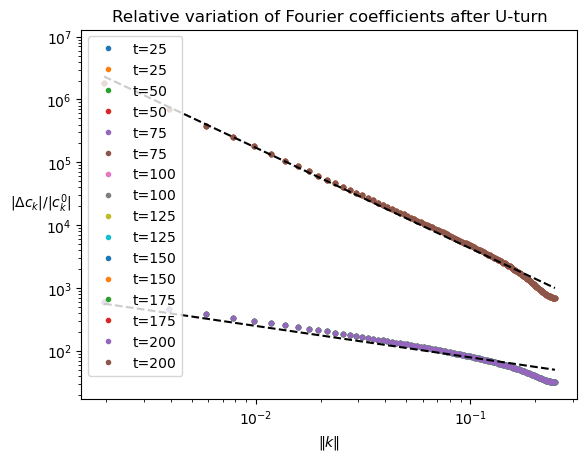

In [197]:
expo_a = 1.*2
kvals = np.fft.fftfreq(256, 2)
for ik, key in enumerate(sorted(data.keys())[:8]):
    # print(ik)
    # k_star = (alpha_bar[key]**(-1) - 1)**(-1/expo_a)
    k_star = 1.
    plt.loglog(kvals / k_star, data[key]['mean_abs_ck0'].mean(axis=1), '.', label=f't={key}')
    plt.loglog(kvals / k_star, data[key]['mean_ck0_norm2'].mean(axis=1), '.', label=f't={key}')

kvals = np.sort(kvals)
plt.loglog(kvals / k_star, 5e1*(kvals/kvals[-1])**(-.5), 'k--')
plt.loglog(kvals / k_star, 1e3*(kvals/kvals[-1])**(-1.6), 'k--')
plt.legend()
plt.xlabel('$\|k\|$')
plt.ylabel('$|\Delta c_k| / |c_k^0|$', rotation=0)
plt.title('Relative variation of Fourier coefficients after U-turn')
# plt.savefig(f'../../plots/forw_back_corr-relative_variation_fourier.png', dpi = 300, bbox_inches='tight')
plt.show()

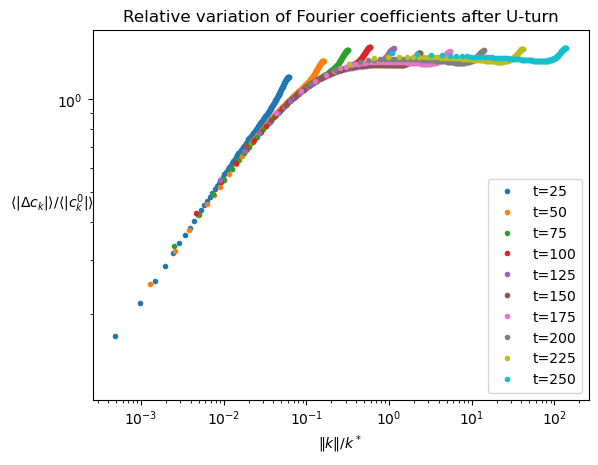

In [208]:
expo_a = 1.6
cut = 10
for ik, key in enumerate(sorted(data.keys())[:10]):
    # print(ik)
    k_star = (alpha_bar[key-1]**(-1) - 1)**(-1/expo_a)
    ystar = (data[key]['mean_abs_delta_ck']/ data[key]['mean_ck0_norm2']).mean()**(-1)
    ystar = 1.
    # k_star = 1.
    # plt.loglog(k_vec / k_star, (data[key]['mean_delta_ck_norm2'].flatten() / data[key]['mean_ck0_norm2'].flatten())**.5, '.', label=f't={key}')
    # plt.loglog(k_vec / k_star, ystar*(data[key]['mean_abs_delta_ck'].flatten() / data[key]['mean_abs_ck0'].flatten()), '.', label=f't={key}')
    plt.loglog(np.fft.fftfreq(256, 2) / k_star, ystar*(data[key]['mean_abs_delta_ck'].mean(axis=1)/ data[key]['mean_abs_ck0'].mean(axis=1)), '.', label=f't={key}')
plt.legend()
plt.xlabel('$\|k\|/ k^*$')
plt.ylabel('$\langle |\Delta c_k|\\rangle / \langle |c_k^0| \\rangle$', rotation=0)
plt.title('Relative variation of Fourier coefficients after U-turn')
# plt.savefig(f'../../plots/forw_back_corr-relative_variation_fourier.png', dpi = 300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_25981/3707240270.py:8: RuntimeWarning: divide by zero encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-0.75), 'k--')
/tmp/ipykernel_25981/3707240270.py:8: RuntimeWarning: invalid value encountered in power
  plt.loglog(kval, 3e1*(kval/kval[-1])**(-0.75), 'k--')


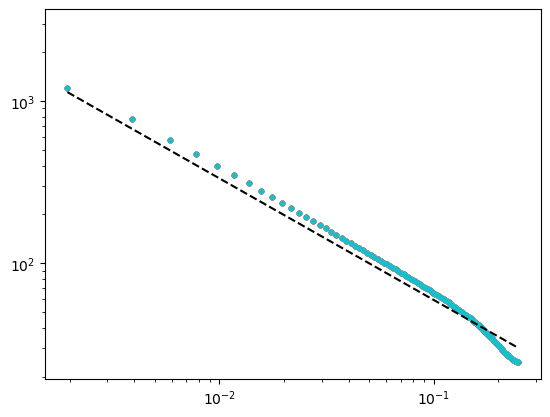

In [102]:
kval = np.fft.fftfreq(256, 2)
for ik, key in enumerate(sorted(data.keys())):
    # k_star = (alpha_bar[ik]**(-1) - 1)**(-1/expo_a)
    k_star = 1.
    # plt.loglog(k_vec / k_star, (data[key]['mean_delta_ck_norm2'].flatten() / data[key]['mean_ck0_norm2'].flatten())**.5, '.', label=f't={key}')
    plt.loglog(kval / k_star, (data[key]['mean_ck0_norm2'].mean(axis=0))**.5, '.', label=f't={key}')
kval = np.sort(kval)
plt.loglog(kval, 3e1*(kval/kval[-1])**(-0.75), 'k--')
plt.show()

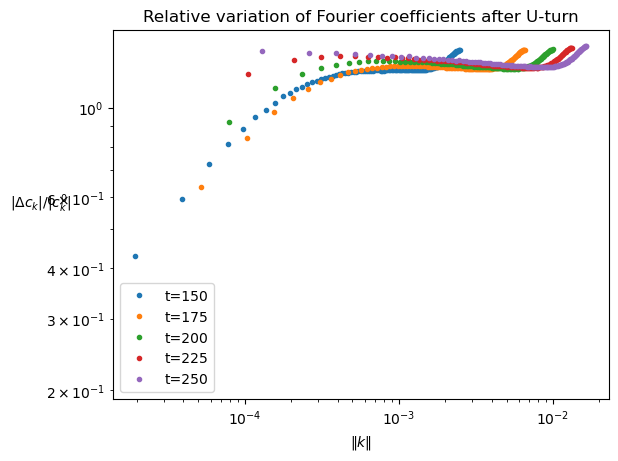

In [139]:
expo_a = 2
for ik, key in enumerate(sorted(data.keys())[5:]):
    k_star = (alpha_bar[ik]**(-1) - 1)**(-1/expo_a)
    ystar = (data[key]['mean_delta_ck_norm2']/ data[key]['mean_ck0_norm2']).mean()**(-1)
    ystar = 1.
    # k_star = 1.
    # plt.loglog(k_vec / k_star, (data[key]['mean_delta_ck_norm2'].flatten() / data[key]['mean_ck0_norm2'].flatten())**.5, '.', label=f't={key}')
    plt.loglog(np.fft.fftfreq(256, 2) / k_star, ystar*(data[key]['mean_delta_ck_norm2'].mean(axis=0) / data[key]['mean_ck0_norm2'].mean(axis=0))**.5, '.', label=f't={key}')
plt.legend()
plt.xlabel('$\|k\|$')
plt.ylabel('$|\Delta c_k| / |c_k^0|$', rotation=0)
plt.title('Relative variation of Fourier coefficients after U-turn')
# plt.savefig(f'../../plots/forw_back_corr-relative_variation_fourier.png', dpi = 300, bbox_inches='tight')
plt.show()

In [34]:
data[key].keys()

dict_keys(['mean_delta_ck_norm2', 'mean_ck0_norm2', 'mean_delta_ck_over_ck0'])

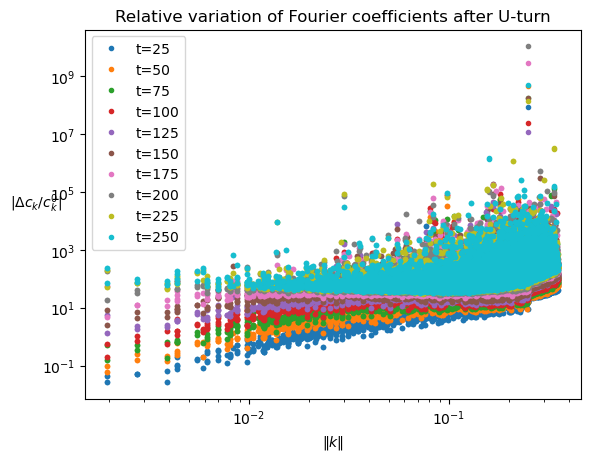

In [35]:
for key in sorted(data.keys()):
    plt.loglog(k_vec, data[key]['mean_delta_ck_over_ck0'].flatten(), '.', label=f't={key}')
plt.legend()
plt.xlabel('$\|k\|$')
plt.ylabel('$|\Delta c_k / c_k^0|$', rotation=0)
plt.title('Relative variation of Fourier coefficients after U-turn')
# plt.savefig(f'../../plots/forw_back_corr-relative_variation_fourier.png', dpi = 300, bbox_inches='tight')
plt.show()

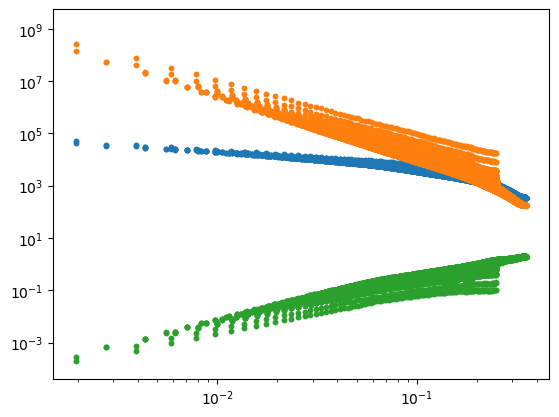

In [17]:
plt.loglog(k_vec, delta_ck['mean_delta_ck_norm2'].flatten(), '.')
plt.loglog(k_vec, delta_ck['mean_ck0_norm2'].flatten(), '.')
plt.loglog(k_vec, delta_ck['mean_delta_ck_norm2'].flatten() / delta_ck['mean_ck0_norm2'].flatten(), '.')

In [45]:
# import enum
import math

import numpy as np
# import torch as th

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [52]:
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

In [51]:
file_args = '../datasets/diffused_ILSVRC2012_validation/t_25_250_args_2024-01-19-23-29-10-184671.pk'
with open(file_args, 'rb') as f:
    args = pickle.load(f)
print(args)

Namespace(clip_denoised=True, num_samples=10000, batch_size=32, use_ddim=False, model_path='models/256x256_diffusion_uncond.pt', image_size=256, num_channels=256, num_res_blocks=2, num_heads=4, num_heads_upsample=-1, num_head_channels=64, attention_resolutions='32,16,8', channel_mult='', dropout=0.0, class_cond=False, use_checkpoint=False, use_scale_shift_norm=True, resblock_updown=True, use_fp16=True, use_new_attention_order=False, learn_sigma=True, diffusion_steps=1000, noise_schedule='linear', timestep_respacing='250', use_kl=False, predict_xstart=False, rescale_timesteps=False, rescale_learned_sigmas=False, step_reverse=25, data_dir='/scratch/izar/sclocchi/datasets/ILSVRC2012/validation', output='/scratch/izar/sclocchi/guided-diffusion/results/diffused_ILSVRC2012_validation', num_per_class=10, num_classes=1000)


In [53]:
model, diffusion = create_model_and_diffusion(
    **args_to_dict(args, model_and_diffusion_defaults().keys())
)

In [57]:
diffusion.__dir__()

['use_timesteps',
 'timestep_map',
 'original_num_steps',
 'timestep_reverse_map',
 'model_mean_type',
 'model_var_type',
 'loss_type',
 'rescale_timesteps',
 'betas',
 'num_timesteps',
 'alphas_cumprod',
 'alphas_cumprod_prev',
 'alphas_cumprod_next',
 'sqrt_alphas_cumprod',
 'sqrt_one_minus_alphas_cumprod',
 'log_one_minus_alphas_cumprod',
 'sqrt_recip_alphas_cumprod',
 'sqrt_recipm1_alphas_cumprod',
 'posterior_variance',
 'posterior_log_variance_clipped',
 'posterior_mean_coef1',
 'posterior_mean_coef2',
 '__module__',
 '__doc__',
 '__init__',
 'p_mean_variance',
 'training_losses',
 'condition_mean',
 'condition_score',
 '_wrap_model',
 '_scale_timesteps',
 'q_mean_variance',
 'q_sample',
 'q_posterior_mean_variance',
 '_predict_xstart_from_eps',
 '_predict_xstart_from_xprev',
 '_predict_eps_from_xstart',
 'p_sample',
 'p_sample_loop',
 'p_sample_loop_progressive',
 'ddim_sample',
 'ddim_reverse_sample',
 'ddim_sample_loop',
 'ddim_sample_loop_progressive',
 '_vb_terms_bpd',
 '_pr

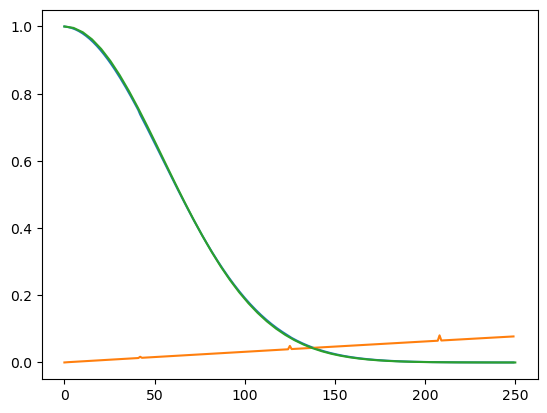

In [70]:
plt.plot(diffusion.alphas_cumprod)
plt.plot(diffusion.betas)
tv = np.linspace(0, 250)
plt.plot(tv, np.exp(-tv**2/6000))

# Wavelets

In [6]:
import sys
# import torch
# import matplotlib.pyplot as plt
sys.path.insert(0, '/home/sclocchi')
# from guided_diffusion.image_datasets import load_data
# from local_probability_models_of_images.code.model_loader_func import load_multi_scale_denoisers_RF, load_BF_CNN_RF
from local_probability_models_of_images.code.wavelet_func import multi_scale_decompose

In [7]:
wv_coeff = {}

for key in sorted(img_t.keys()):
    wv_coeff[key] = multi_scale_decompose(img_t[key], J = 8, device=torch.device('cpu'))
    print(len(wv_coeff[key]), wv_coeff[key][0].shape)

8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])
8 torch.Size([12, 128, 128])


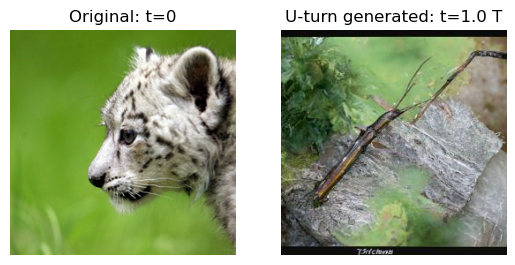

In [8]:
t = 250

fig, axs = plt.subplots(1, 2)

for ax in axs:
    ax.axis('off')
    ax.set_aspect('equal')
axs[0].imshow(img_t[0].transpose(1, 2, 0))
axs[1].imshow(img_t[t].transpose(1, 2, 0))
axs[0].set_title('Original: t=0')
axs[1].set_title(f'U-turn generated: t={(t/250):.1f} T')
# fig.savefig(f'../../plots/forw_back_corr-sample_img_t{t}.png', dpi = 300, bbox_inches='tight')
plt.show()

In [18]:
wv_coeff[0][sc].norm(dim=0).shape

torch.Size([128, 128])

In [15]:
wv_coeff[0][sc][ch:(ch+3)].permute(1, 2, 0).shape

torch.Size([128, 128, 3])

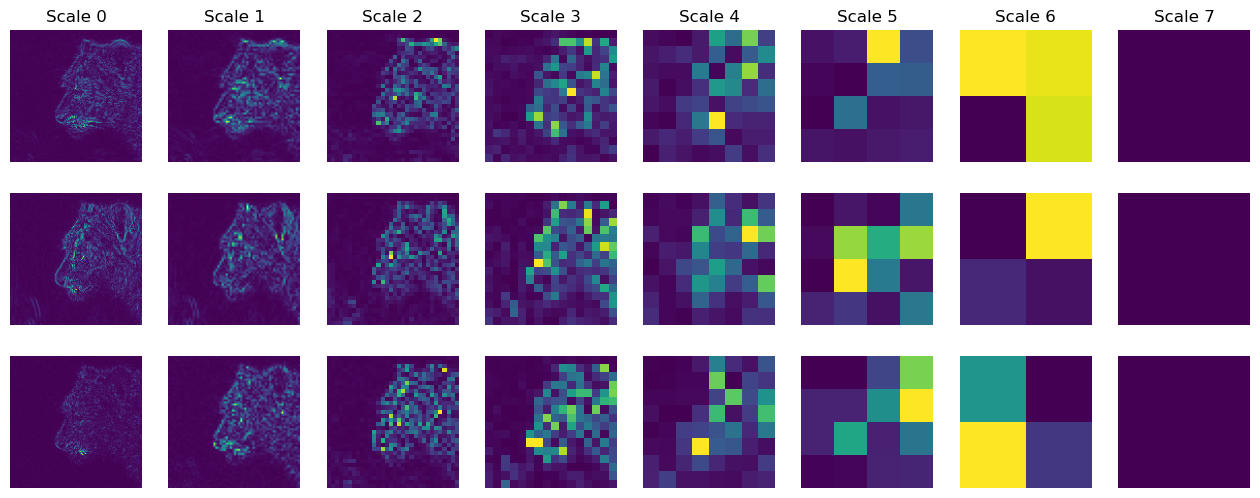

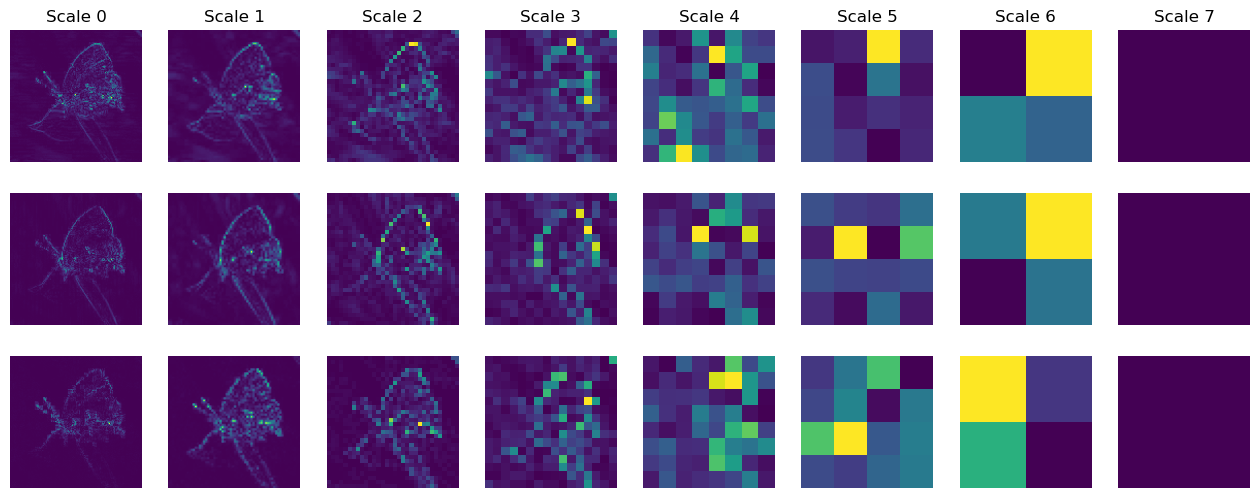

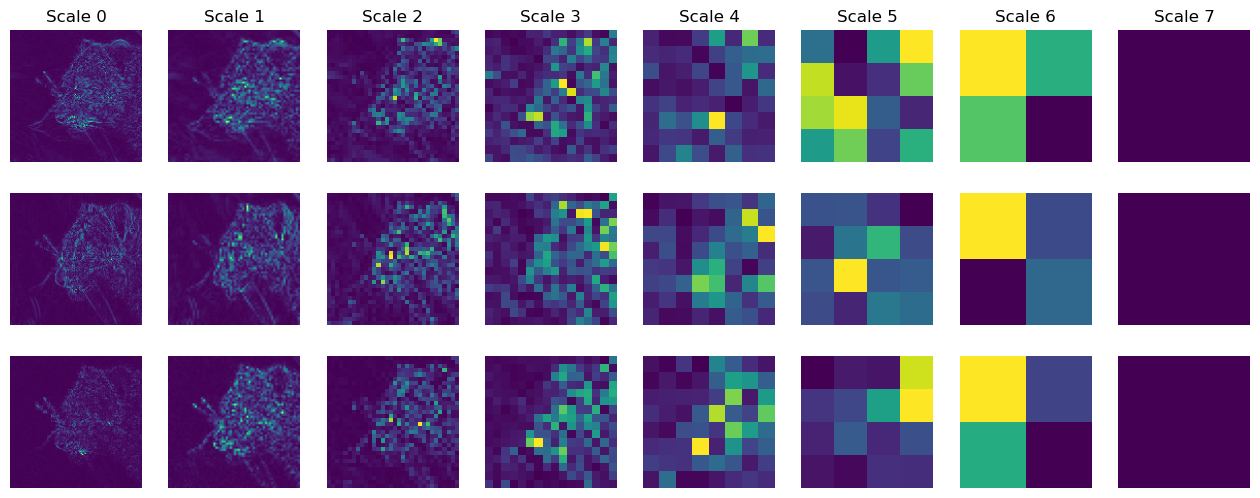

In [18]:
t = 175

fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for sc in range(8):
    for kk in range(3):
        ch = 3*(kk+1)
        axs[kk, sc].axis('off')
        axs[kk, sc].set_aspect('equal')
        axs[kk, sc].imshow(wv_coeff[0][sc][ch:(ch+3)].norm(dim=0))
        # axs[sc].imshow(wv_coeff[0][sc][3:6].norm(dim=0))
        axs[0,sc].set_title(f'Scale {sc}')
# Adjust vertical space between subplots
# plt.subplots_adjust(hspace=0.0)
plt.show()

fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for sc in range(8):
    for kk in range(3):
        ch = 3*(kk+1)
        axs[kk, sc].axis('off')
        axs[kk, sc].set_aspect('equal')
        axs[kk, sc].imshow(wv_coeff[t][sc][ch:(ch+3)].norm(dim=0))
        # axs[sc].imshow(wv_coeff[0][sc][3:6].norm(dim=0))
        axs[0,sc].set_title(f'Scale {sc}')
# Adjust vertical space between subplots
# plt.subplots_adjust(hspace=0.0)
plt.show()

fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for sc in range(8):
    for kk in range(3):
        ch = 3*(kk+1)
        axs[kk, sc].axis('off')
        axs[kk, sc].set_aspect('equal')
        axs[kk, sc].imshow((wv_coeff[t][sc][ch:(ch+3)]-wv_coeff[0][sc][ch:(ch+3)]).norm(dim=0))
        # axs[sc].imshow(wv_coeff[0][sc][3:6].norm(dim=0))
        axs[0,sc].set_title(f'Scale {sc}')
# Adjust vertical space between subplots
# plt.subplots_adjust(hspace=0.0)
plt.show()


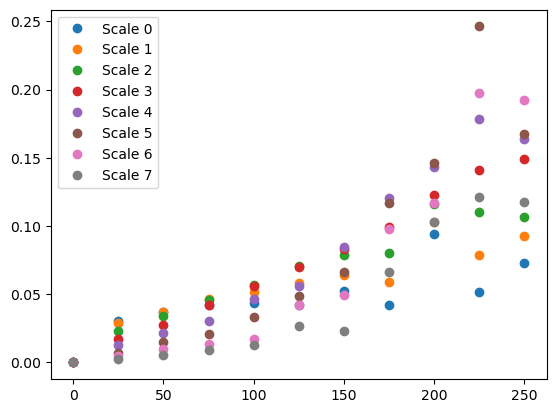

In [51]:
fig, ax = plt.subplots()

for t in sorted(wv_coeff.keys()):
    for sc in range(8):
        # for kk in range(3):
            # ch = 3*(kk+1)
        val = (wv_coeff[t][sc][3:]-wv_coeff[0][sc][3:]).norm(dim=0)
        # val = (wv_coeff[t][sc][3:]-wv_coeff[0][sc][3:]).mean()
        label=None
        if t==25:
            label = f'Scale {sc}'
        ax.plot(t, val.mean(), 'o', color = f"C{sc}", label=label)
        # ax.plot(t, val, 'o', color = f"C{sc}", label=label)

        # axs[kk, sc].axis('off')
        # axs[kk, sc].set_aspect('equal')
        # axs[kk, sc].imshow((wv_coeff[t][sc][ch:(ch+3)]-wv_coeff[0][sc][ch:(ch+3)]).norm(dim=0))
        # # axs[sc].imshow(wv_coeff[0][sc][3:6].norm(dim=0))
        # axs[0,sc].set_title(f'Scale {sc}')
# Adjust vertical space between subplots
# plt.subplots_adjust(hspace=0.0)
plt.legend()
plt.show()

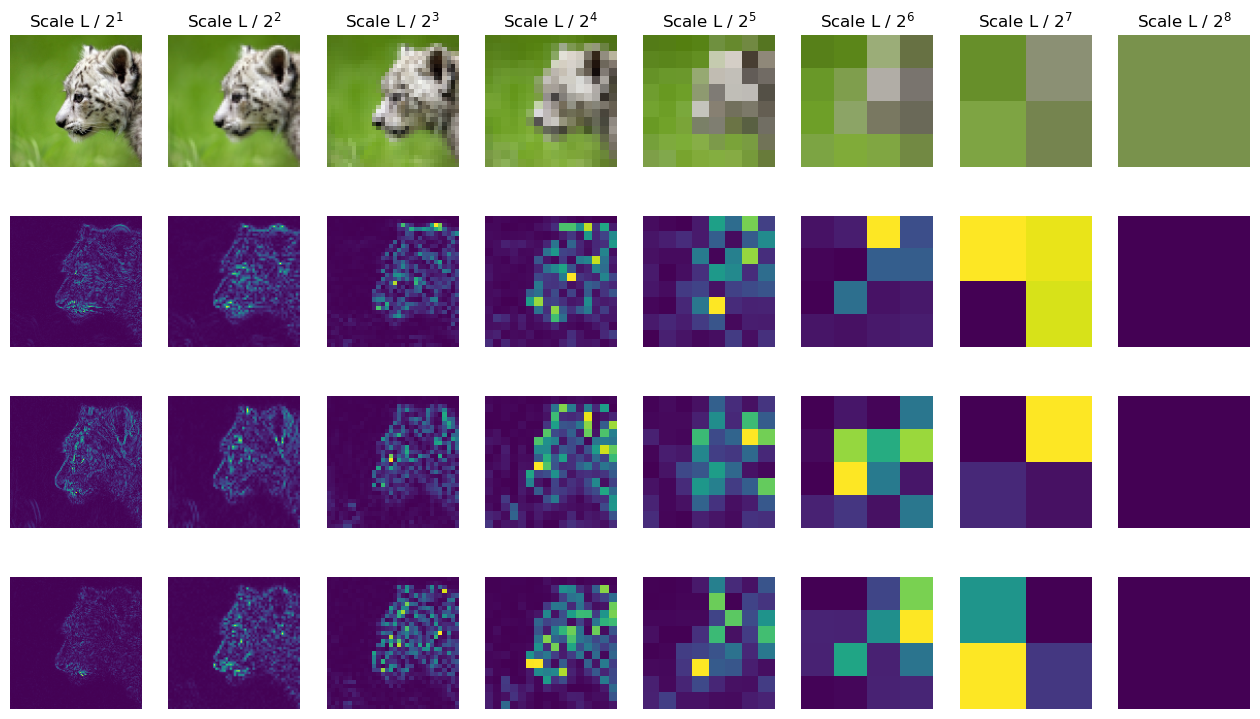

In [23]:
fig, axs = plt.subplots(4, 8, figsize=(16, 9))
for sc in range(8):
    for kk in range(4):
        ch = 3*(kk)
        axs[kk, sc].axis('off')
        axs[kk, sc].set_aspect('equal')
        image = wv_coeff[0][sc][ch:(ch+3)].permute(1,2,0) if kk==0 else wv_coeff[0][sc][ch:(ch+3)].norm(dim=0)
        # axs[kk, sc].imshow(wv_coeff[0][sc][ch:(ch+3)].norm(dim=0))
        axs[kk, sc].imshow(image)
        # axs[sc].imshow(wv_coeff[0][sc][3:6].norm(dim=0))
        axs[0,sc].set_title(f'Scale L / $2^{sc+1}$')
# Adjust vertical space between subplots
# plt.subplots_adjust(hspace=0.0)
# fig.savefig(f'../../plots/wavelet-sample_img_t0.png', dpi = 300, bbox_inches='tight')
plt.show()